### COLLABORATIVE FILTERING USING THE NETFLIX DATA
In this notebook, Alternating Least Squares (ALS) algorithm will be used with Spark APIs to predict the ratings for the movies 

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from pyspark.ml.tuning import CrossValidator
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType

%matplotlib inline


## Problem 2: Data ETL and Data Exploration

In [39]:
spark = SparkSession \
    .builder \
    .appName("moive analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [40]:

schema = StructType([
    StructField("movieId", IntegerType(), True),
    StructField("year", IntegerType(), True),
    StructField("name", StringType(), True)])

movies_df = spark.read.load("movie_titles.txt", format='csv',header=False,schema=schema)
movies_df.createOrReplaceTempView("movies_df")


In [72]:
movies_df.show(5)

+-------+----+--------------------+
|movieId|year|                name|
+-------+----+--------------------+
|      1|2003|     Dinosaur Planet|
|      2|2004|Isle of Man TT 20...|
|      3|1997|           Character|
|      4|1994|Paula Abdul's Get...|
|      5|2004|The Rise and Fall...|
+-------+----+--------------------+
only showing top 5 rows



In [41]:
schema_ratings_df = StructType([
    StructField("movieId", IntegerType(), True),
    StructField("userID", IntegerType(), True),
    StructField("ratings", FloatType(), True)])
ratings_df = spark.read.load("TrainingRatings.txt", format='csv',header=False,schema=schema_ratings_df)


In [87]:

schema_ratings_df = StructType([
    StructField("movieId", IntegerType(), True),
    StructField("userID", IntegerType(), True),
    StructField("ratings", FloatType(), True)])
ratings_Testing_df = spark.read.load("TestingRatings.txt", format='csv',header=False,schema=schema_ratings_df)

In [42]:
tmp1 = ratings_df.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings_df.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 68
Minimum number of ratings per movie is 3


Text(0.5, 1.0, 'rating counts')

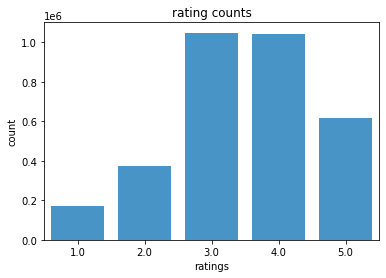

In [70]:
import seaborn as sns

sns.barplot(x="ratings", y="count", color='#3498db', data=ratings_df.groupBy('ratings').count().toPandas()).set_title('rating counts')


### Problem 3: Collaborative Filtering Implementation

With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [89]:
# import package
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

In [91]:
# Create ALS model
# Build the recommendation model using ALS on the training data
# Note we set cold start strategy to 'drop' to ensure we don't get NaN evaluation metrics
als = ALS(maxIter=5, rank=10, regParam=0.01, userCol="userID", itemCol="movieId", ratingCol="ratings",
          coldStartStrategy="drop")

#Tune model using ParamGridBuilder
# it will take long time in the cv period, so just use few parameter to try 

paramGrid = (ParamGridBuilder()
             .addGrid(als.regParam, [0.01])
             .addGrid(als.rank, [10])
             .addGrid(als.maxIter, [15])
             .build())

# Define evaluator as RMSE

evaluator = RegressionEvaluator(metricName="rmse", labelCol="ratings",
                                predictionCol="prediction")

# Build Cross validation 
# Create 5-fold CrossValidator
# it takes too long that I only use 2-fold
cv = CrossValidator(estimator=als, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=2)

# Run cross validations
cvModel = cv.fit(ratings_df)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

In [46]:
# Extract the best model selected by CV
best_model = cvModel.bestModel

In [47]:
#Fit ALS model to training data

# specify parameter settings by the best model obtained via CV
print ("**Best Model**")
print ("Rank: ", best_model)
print (" MaxIter: ", str(best_model._java_obj.parent().getMaxIter()))
print (" RegParam:",  best_model._java_obj.parent().regParam())

**Best Model**
Rank:  ALSModel: uid=ALS_c5fc35861b3d, rank=10
 MaxIter:  15
 RegParam: ALS_c5fc35861b3d__regParam


### Model testing


In [93]:
#Generate predictions and evaluate using RMSE
predictions=best_model.transform(ratings_Testing_df)
rmse = evaluator.evaluate(predictions)
print ("RMSE = "+str(rmse))

RMSE = 0.8539641229349001


In [94]:
#Extract best model from the tuning exercise using ParamGridBuilder

als_best = ALS(maxIter=15, rank=10, regParam=0.01, userCol="userID", itemCol="movieId", ratingCol="ratings",
          coldStartStrategy="drop")
model = als_best.fit(ratings_df)
alldata=model.transform(ratings_Testing_df)
rmse = evaluator.evaluate(alldata)
print ("RMSE = "+str(rmse))

RMSE = 0.8389696976575549


### Result Viewing

In [52]:
user_recs = best_model.recommendForAllUsers(2)
user_recs.registerTempTable("als_recs_temp")
user_recs.show(10)

+------+--------------------+
|userID|     recommendations|
+------+--------------------+
| 15846|[{17337, 7.680398...|
| 16386|[{14648, 4.066045...|
|128389|[{16467, 5.876249...|
|151871|[{17337, 5.239189...|
|205371|[{12952, 7.854920...|
|263031|[{2985, 4.770199}...|
|279120|[{218, 5.305906},...|
|284489|[{12952, 5.47773}...|
|302344|[{17337, 5.726063...|
|331295|[{17337, 5.742091...|
+------+--------------------+
only showing top 10 rows



In [53]:
# seperate the value of 'recommendations' in user_recs

explode_rec = spark.sql('SELECT userId,\
                                explode(recommendations) AS MovieRec\
                                FROM als_recs_temp')

explode_rec.createOrReplaceTempView("explode_rec")

explode_rec.show(10)

+------+------------------+
|userId|          MovieRec|
+------+------------------+
| 15846|{17337, 7.6803985}|
| 15846|{14324, 5.3869762}|
| 16386|{14648, 4.0660458}|
| 16386|{14361, 3.9452302}|
|128389| {16467, 5.876249}|
|128389|  {5142, 5.842342}|
|151871|{17337, 5.2391896}|
|151871| {1779, 5.0404043}|
|205371|{12952, 7.8549204}|
|205371|  {3706, 6.840836}|
+------+------------------+
only showing top 10 rows



In [54]:
final_recs = spark.sql("SELECT userId,\
                               movieIds_and_ratings.movieId AS movieId,\
                               movieIds_and_ratings.rating AS prediction\
                               FROM als_recs_temp\
                               LATERAL VIEW explode(recommendations) exploded_table AS movieIds_and_ratings")

final_recs.createOrReplaceTempView("final_recs")

final_recs.show(10)

+------+-------+----------+
|userId|movieId|prediction|
+------+-------+----------+
| 15846|  17337| 7.6803985|
| 15846|  14324| 5.3869762|
| 16386|  14648| 4.0660458|
| 16386|  14361| 3.9452302|
|128389|  16467|  5.876249|
|128389|   5142|  5.842342|
|151871|  17337| 5.2391896|
|151871|   1779| 5.0404043|
|205371|  12952| 7.8549204|
|205371|   3706|  6.840836|
+------+-------+----------+
only showing top 10 rows



In [84]:
df1 = final_recs 
df2 = movies_df
df = df1.join(df2,( df1.movieId == df2.movieId) & (df1.userId == 1744889)  ).select(df1.userId,df2.name)

In [85]:
df.show(10)

+-------+--------------------+
| userId|                name|
+-------+--------------------+
|1744889|The Great Ecstasy...|
|1744889| Andromeda: Season 5|
+-------+--------------------+

